## Домашняя работа по теме "Сегментация"

1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Можете взять один из этих наборов данных:

https://www.kaggle.com/carlolepelaars/camvid

https://www.kaggle.com/dansbecker/cityscapes-image-pairs

https://www.kaggle.com/tapakah68/segmentation-full-body-mads-dataset

https://www.kaggle.com/longnguyen2306/bacteria-detection-with-darkfield-microscopy

https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
IMG_CHANNELS, IMG_WIDTH, IMG_HEIGHT = 3, 512, 512

In [3]:
X = next(os.walk('segmentation_full_body_mads_dataset_1192_img/images'))[2]
y = next(os.walk('segmentation_full_body_mads_dataset_1192_img/masks'))[2]

In [4]:
X_ids = X[:-10]
y_ids = y[:-10]

Pre-processing:

* Присвоение исходных значений X_train и y_train, перебор имени файла.
* Загрузка изображения с помощью keras load_img.
* Преобразование массива img в np с использованием img_to_array и нарезки
* Преобразование массива в формат PIL для изменения его размера до (256, 256){INPUT SIZE}
* Замена нулей в X_train значениями массива изображений
* У y_train добавление дополнительного измерения с помощью np.newaxis

In [5]:
X_train = np.zeros((len(X_ids), 256, 256, 3), dtype=np.float32)
y_train = np.zeros((len(y_ids), 256, 256, 1), dtype=np.bool)

C:\Users\Полина\AppData\Local\Temp\ipykernel_11520\522299476.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = np.zeros((len(y_ids), 256, 256, 1), dtype=np.bool)


In [6]:
for n, id_ in enumerate(X_ids):
    image = tf.keras.preprocessing.image.load_img(f'segmentation_full_body_mads_dataset_1192_img/images/{id_}', target_size=(IMG_HEIGHT, IMG_WIDTH))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)[90:450,150:406]
    image = tf.keras.preprocessing.image.array_to_img(input_arr, ).resize((256, 256))
    X_train[n] = np.array(image)

In [7]:
for n, id_ in enumerate(y_ids):
    image = tf.keras.preprocessing.image.load_img(f'segmentation_full_body_mads_dataset_1192_img/masks/{id_}', 
                                                  target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)[90:450,150:406]
    image = tf.keras.preprocessing.image.array_to_img(input_arr).resize((256, 256))
    y_train[n] = np.array(image)[:, :, np.newaxis]

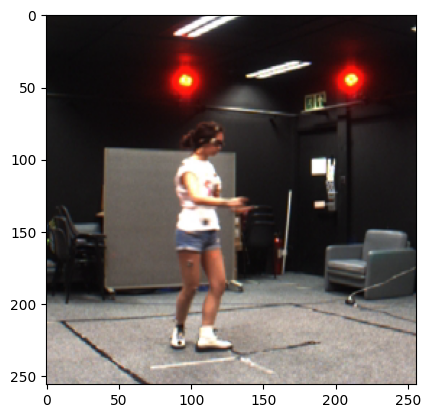

In [8]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(X_train[500]))

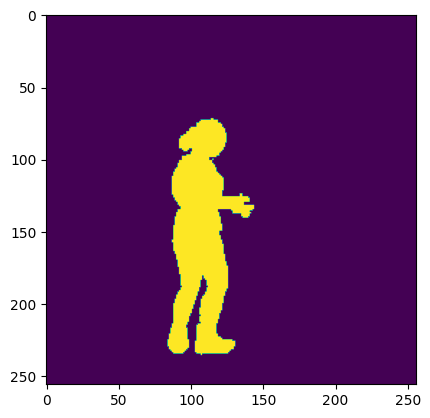

In [9]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(y_train[500]))

### U-net Модель

In [10]:
inputs = tf.keras.layers.Input((256, 256, 3))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

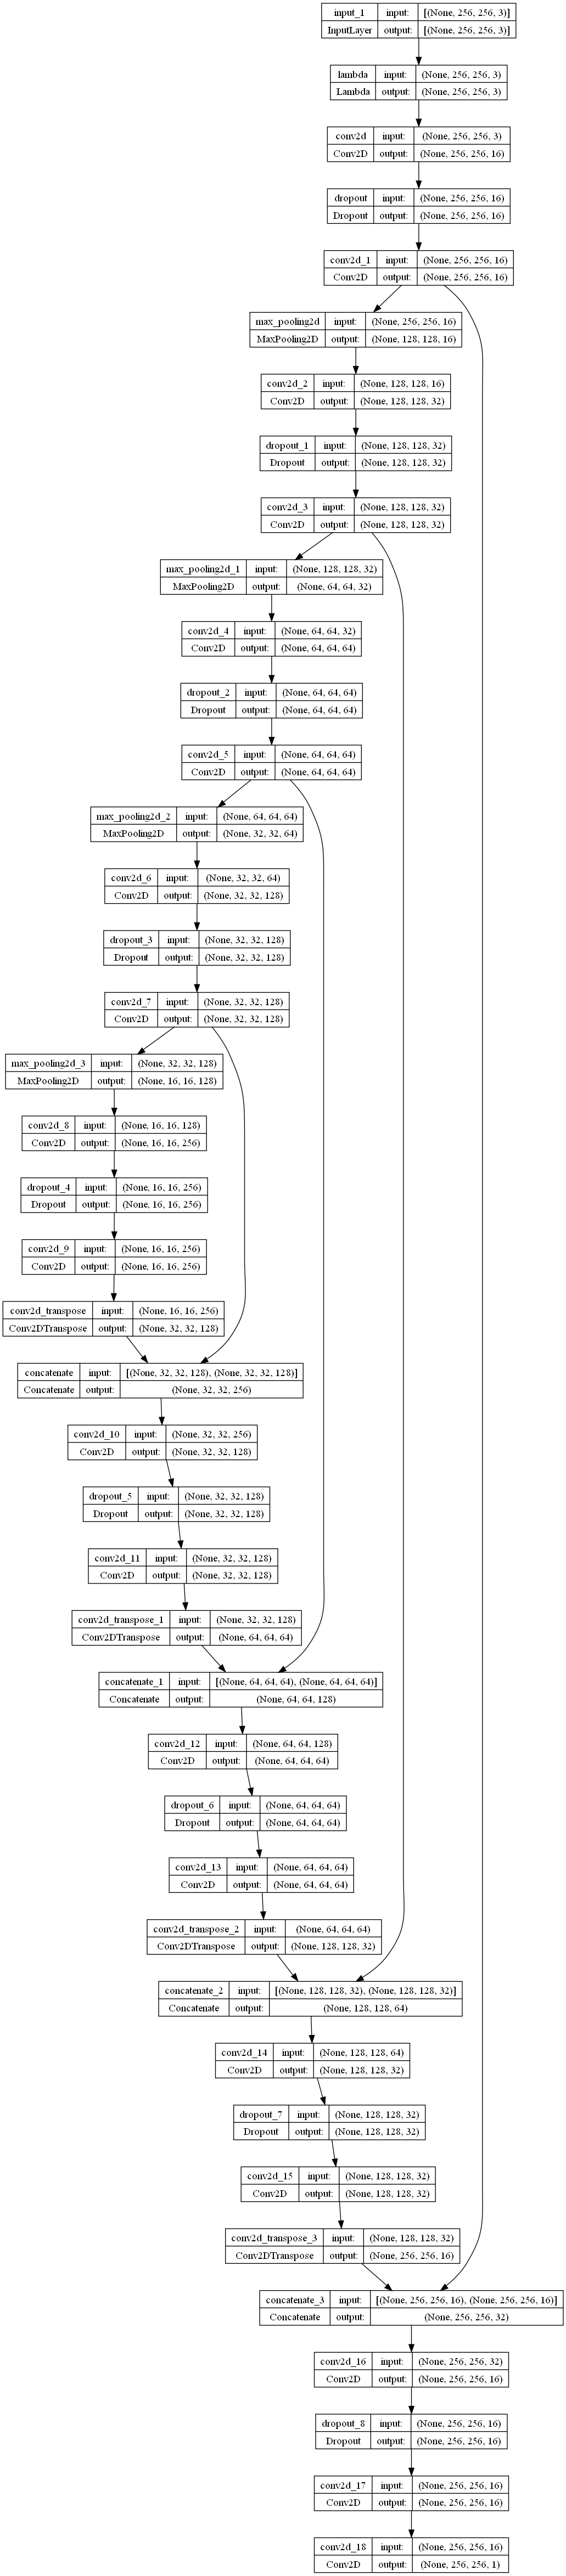

In [12]:
tf.keras.utils.plot_model(model, to_file='./model.png', show_shapes=True)

### Обучение модели

In [14]:
results = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=2)

Epoch 1/2
67/67 [==============================] - 537s 8s/step - loss: 0.0533 - accuracy: 0.9794 - val_loss: 0.1008 - val_accuracy: 0.9624
Epoch 2/2
67/67 [==============================] - 531s 8s/step - loss: 0.0425 - accuracy: 0.9835 - val_loss: 0.0677 - val_accuracy: 0.9743


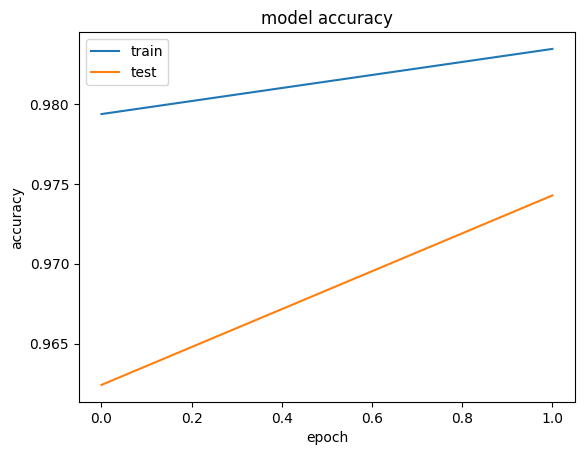

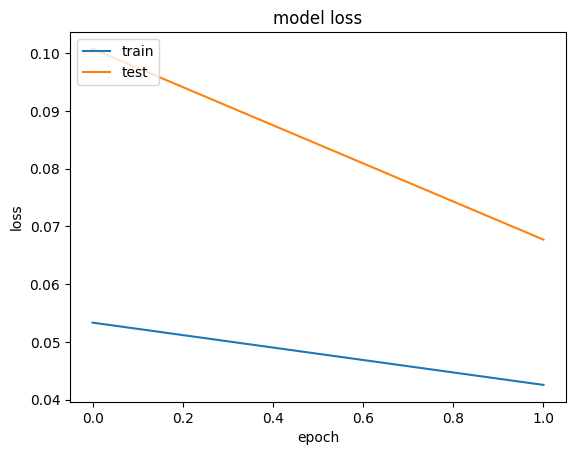

In [15]:
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

С увеличением epochs точность модели повышается

### Предсказание

In [16]:
import random

test_id = random.choice(X_ids[-10:])
print(test_id)

Taichi_S6_C1_00225.png


In [17]:
img = tf.keras.preprocessing.image.load_img(f"segmentation_full_body_mads_dataset_1192_img/images/{test_id}", target_size=(256, 256))
input_array = tf.keras.preprocessing.image.img_to_array(img)
input_array = np.array([input_array])  # Convert single image to a batch.
predictions = model.predict(input_array)

1/1 [==============================] - 0s 435ms/step


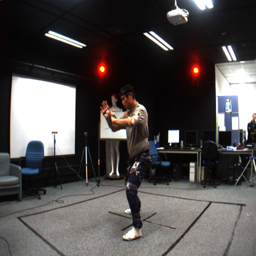

In [18]:
Image.open(f"segmentation_full_body_mads_dataset_1192_img/images/{test_id}").resize((256, 256))

Предсказанное изображение:

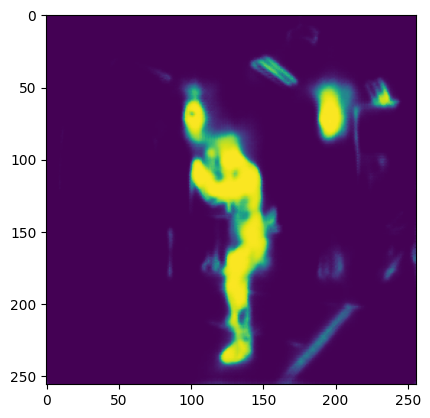

In [19]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(np.squeeze(predictions)[:, :, np.newaxis]))

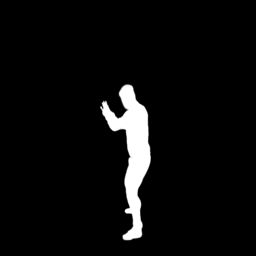

In [20]:
Image.open(f"segmentation_full_body_mads_dataset_1192_img/masks/{test_id}").resize((256 ,256))